In [280]:
### import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
 
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline
plt.style.use('ggplot')

from catboost import CatBoostClassifier # Or CatBoostRegressor
from sklearn.model_selection import KFold
from itertools import product,chain

import shap
import catboost
from catboost import *
from sklearn.naive_bayes import GaussianNB
import random
import paramsearch

from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, classification_report

np.random.seed(0)
random.seed(0)

In [331]:
def read_data():
    target = pd.read_csv("./data/Target.csv")
    ben_data = pd.read_csv("./data/Beneficiarydata.csv")
    in_pt_data = pd.read_csv("./data/Inpatientdata.csv")
    out_pt_data = pd.read_csv("./data/Outpatientdata.csv")
    return (in_pt_data, out_pt_data, ben_data, target)

In [282]:
def N_unique_values(df):
    return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

## Explore datasets 

In [332]:
### Load Train data
in_pt, out_pt, ben, target = read_data()

In [333]:
ben.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [285]:
ben.describe()

,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,...,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
mean,1.570932,1.254511,25.666734,374.424745,11.907727,11.910145,1.667817,1.506322,1.687643,1.880041,...,1.644476,1.398142,1.324143,1.725317,1.743180,1.920942,3660.346502,399.847296,1298.219348,377.718258
std,0.494945,0.717007,15.223443,266.277581,1.032332,0.936893,0.470998,0.499962,0.463456,0.324914,...,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,1.000000,1.000000,11.000000,141.000000,12.000000,12.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,170.000000,40.000000
50%,2.000000,1.000000,25.000000,340.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,570.000000,170.000000
75%,2.000000,1.000000,39.000000,570.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2280.000000,1068.000000,1500.000000,460.000000
max,2.000000,5.000000,54.000000,999.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,161470.000000,38272.000000,102960.000000,13840.000000


In [286]:
ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [287]:
print(ben.RenalDiseaseIndicator.unique())

['0' 'Y']


In [288]:
ben = ben.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
                  0)
ben = ben.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})

In [289]:
ben.describe()

,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,...,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
mean,0.429068,1.254511,0.141300,25.666734,374.424745,11.907727,11.910145,0.332183,0.493678,0.312357,...,0.355524,0.601858,0.675857,0.274683,0.256820,0.079058,3660.346502,399.847296,1298.219348,377.718258
std,0.494945,0.717007,0.348332,15.223443,266.277581,1.032332,0.936893,0.470998,0.499962,0.463456,...,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,0.000000,1.000000,0.000000,11.000000,141.000000,12.000000,12.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,170.000000,40.000000
50%,0.000000,1.000000,0.000000,25.000000,340.000000,12.000000,12.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,570.000000,170.000000
75%,1.000000,1.000000,0.000000,39.000000,570.000000,12.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2280.000000,1068.000000,1500.000000,460.000000
max,1.000000,5.000000,1.000000,54.000000,999.000000,12.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,161470.000000,38272.000000,102960.000000,13840.000000


In [290]:
in_pt.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [291]:
in_pt.describe()

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
count,40474.000000,39575.0,23148.000000,5454.000000,965.000000,116.000000,9.000000,0.0
mean,10087.884074,1068.0,5894.611759,4103.738174,4226.355440,4070.172414,5269.444444,NaN
std,10303.099402,0.0,3049.304400,2028.182156,2282.761581,1994.409802,2780.071632,NaN
min,0.000000,1068.0,11.000000,42.000000,42.000000,42.000000,2724.000000,NaN
25%,4000.000000,1068.0,3848.000000,2724.000000,2724.000000,2758.750000,4139.000000,NaN
50%,7000.000000,1068.0,5369.000000,4019.000000,4019.000000,4019.000000,4139.000000,NaN
75%,12000.000000,1068.0,8666.250000,4439.000000,5185.000000,4439.000000,5185.000000,NaN
max,125000.000000,1068.0,9999.000000,9999.000000,9999.000000,9986.000000,9982.000000,NaN


In [292]:
in_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

In [293]:
out_pt.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [294]:
out_pt.describe()

,InscClaimAmtReimbursed,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid
count,517737.000000,162.000000,36.000000,4.000000,2.000000,0.0,0.0,517737.000000
mean,286.334799,6116.611111,4503.277778,2959.000000,4075.500000,NaN,NaN,2.779233
std,694.034343,3217.719258,2504.015000,1863.455393,5323.806956,NaN,NaN,15.785839
min,0.000000,51.000000,412.000000,412.000000,311.000000,NaN,NaN,0.000000
25%,40.000000,3893.000000,2724.000000,2146.000000,2193.250000,NaN,NaN,0.000000
50%,80.000000,5244.500000,4019.000000,3511.500000,4075.500000,NaN,NaN,0.000000
75%,200.000000,9421.500000,5849.000000,4324.500000,5957.750000,NaN,NaN,0.000000
max,102500.000000,9999.000000,9982.000000,4401.000000,7840.000000,NaN,NaN,897.000000


In [295]:
out_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  517737 non-null  object 
 1   ClaimID                 517737 non-null  object 
 2   ClaimStartDt            517737 non-null  object 
 3   ClaimEndDt              517737 non-null  object 
 4   Provider                517737 non-null  object 
 5   InscClaimAmtReimbursed  517737 non-null  int64  
 6   AttendingPhysician      516341 non-null  object 
 7   OperatingPhysician      90617 non-null   object 
 8   OtherPhysician          195046 non-null  object 
 9   ClmDiagnosisCode_1      507284 non-null  object 
 10  ClmDiagnosisCode_2      322357 non-null  object 
 11  ClmDiagnosisCode_3      203257 non-null  object 
 12  ClmDiagnosisCode_4      125596 non-null  object 
 13  ClmDiagnosisCode_5      74344 non-null   object 
 14  ClmDiagnosisCode_6  

In [296]:
print(target.shape)
target.head()

(5410, 2)


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [297]:
target.groupby('PotentialFraud').count()

,Provider
PotentialFraud,
No,4904
Yes,506


# Data Cleaning

In [298]:
# Replace values with a binary annotation
ben = ben.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
                  0)
ben = ben.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})

# Change target variable to binary
target["target"] = np.where(target.PotentialFraud == "Yes", 1, 0) 
target.drop('PotentialFraud', axis=1, inplace=True)

In [299]:
# Merge in_pt, out_pt and ben df into a single patient dataset
data = pd.merge(in_pt, out_pt,
                    left_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                    right_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                    how = 'outer').\
          merge(ben,left_on='BeneID',right_on='BeneID',how='inner')

In [300]:
patient_merge_id = [i for i in out_pt.columns if i in in_pt.columns]

# Merge in_pt, out_pt and ben df into a single patient dataset
data = pd.merge(in_pt, out_pt,
                    left_on = patient_merge_id,
                    right_on = patient_merge_id,
                    how = 'outer').\
          merge(ben,left_on='BeneID',right_on='BeneID',how='inner')


# Feature engineering 

In [301]:
# We find the number of unique physicians 
data['N_unique_Physicians'] = N_unique_values(data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 

# We separate the types of physicians into numeric values
data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(data[['AttendingPhysician','OperatingPhysician',
                                                                                      'OtherPhysician']].isnull(), 0, 1)

# We count the number of types of physicians that attend the patient
data['N_Types_Physicians'] = data['AttendingPhysician'] +  data['OperatingPhysician'] + data['OtherPhysician']

# Now we create a variable to check if there is a single doctor on a patient that was attended by more than 1 type of doctor
# This helps us finds those cases that are only looked at by 1 physicians
data['Same_Physician'] = data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 1 and x['N_Types_Physicians'] > 1) else 0,axis=1)

# Similar to Same_Physician, we create a variable to see if 1 physicians has had multiple roles, but has not been alone reviewing the case
data['Same_Physician2'] = data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 2 and x['N_Types_Physicians'] > 2) else 0,axis=1)

# We check our new variables
data[['N_unique_Physicians','N_Types_Physicians','Same_Physician','Same_Physician2']].head()

,N_unique_Physicians,N_Types_Physicians,Same_Physician,Same_Physician2
0,1,1,0,0
1,1,2,1,0
2,2,2,0,0
3,3,3,0,0
4,1,1,0,0


In [302]:
# We count the number of procedures for each claim, we drop the initial variables
ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]
data['N_Procedure'] = N_unique_values(data[ClmProcedure_vars])
data = data.drop(ClmProcedure_vars, axis = 1)

# We count the number of claims, we also separate this by unique claims and extra claims, we drop the initial variables
ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]

data['N_Unique_Claims'] = N_unique_values(data[ClmDiagnosisCode_vars])
data['N_Total_Claims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)
data['N_Extra_Claims'] = data['N_Total_Claims'] - data['N_Unique_Claims']

ClmDiagnosisCode_vars.append('N_Total_Claims')
data = data.drop(ClmDiagnosisCode_vars, axis = 1)

In [303]:
#  Transform string columns of date into type date
data['AdmissionDt'] = pd.to_datetime(data['AdmissionDt'] , format = '%Y-%m-%d')
data['DischargeDt'] = pd.to_datetime(data['DischargeDt'],format = '%Y-%m-%d')

data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'],format = '%Y-%m-%d')

data['DOB'] = pd.to_datetime(data['DOB'] , format = '%Y-%m-%d')
data['DOD'] = pd.to_datetime(data['DOD'],format = '%Y-%m-%d')

# Number of days
data['Admission_Days'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days) + 1

# Number of claim days 
data['Claim_Days'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days) + 1

# Age at the time of claim
data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days + 1)/365.25)

In [304]:
# We create a Hospitalization flag 
data['Hospt'] = np.where(data.DiagnosisGroupCode.notnull(), 1, 0)
data = data.drop(['DiagnosisGroupCode'], axis = 1)

# Variable if patient is dead
data['Dead']= 0
data.loc[data.DOD.notna(),'Dead'] = 1

# Handling missing data

In [305]:
na = data.isnull().sum()
na[na != 0]

AdmissionDt          517737
DeductibleAmtPaid       899
DischargeDt          517737
DOD                  554080
Admission_Days       517737
dtype: int64

In [306]:
## We know that missing admission days come from missing admission and discharge date, 
#and this comes from the out patients dataset, so it would be usefull to keep track of this in a stable way

data['Out_Patient'] = 0
data.loc[data['Admission_Days'].isnull(), 'Out_Patient'] = 1 


# We also see that there are some cases of missing deductible amount paid, so we also want to keep an eye on that
data['Missing_Deductible_Amount_Paid'] = 0
data.loc[data['DeductibleAmtPaid'].isnull(), 'Missing_Deductible_Amount_Paid'] = 1 

# After identifying the missing values, we fill the missing values with 0
data = data.fillna(0).copy()

In [307]:
na = data.isnull().sum()
na[na != 0]

Series([], dtype: int64)

## Group by provider each column

In [308]:
### Sum all numeric variables
_sum = data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                    'ChronicCond_Alzheimer', 'AttendingPhysician', 'OperatingPhysician', 
                                                    'OtherPhysician', 'N_unique_Physicians', 'ChronicCond_Heartfailure', 
                                                    'N_Types_Physicians', 'Same_Physician',
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                    'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                    'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'Dead', 
                                                    'N_Procedure','N_Unique_Claims', 'N_Extra_Claims', 'Admission_Days',
                                                    'Claim_Days', 'Hospt', 'Missing_Deductible_Amount_Paid']].sum()

# To separate our variables, we shall add '_sum' at the end of their names
_sum = _sum.add_suffix('_sum')


### Count number of records
_count = data[['BeneID', 'ClaimID']].groupby(data['Provider']).nunique().reset_index()
_count.rename(columns={'BeneID':'BeneID_count','ClaimID':'ClaimID_count'},inplace=True)


### Calculate mean for all numeric variables
_mean = data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                      'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                      'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
                                                      'AttendingPhysician', 'OperatingPhysician','OtherPhysician',
                                                      'N_unique_Physicians', 'ChronicCond_Heartfailure', 
                                                      'N_Types_Physicians', 'Same_Physician',
                                                      'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                      'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                      'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                      'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                      'ChronicCond_stroke', 'Dead', 'N_Procedure','N_Unique_Claims', 
                                                      'N_Extra_Claims', 'Admission_Days','Claim_Days', 'Hospt',
                                                      'Missing_Deductible_Amount_Paid'
                                                   ]].mean()

# To separate our variables, we shall add '_mean' at the end of their names
_mean = _mean.add_suffix('_mean')

# We create a dataset that holds all the variables
_total = _count.merge(_sum, how='left',left_on='Provider',right_on='Provider_sum').\
                merge(_mean, how='left',left_on='Provider',right_on='Provider_mean').\
                drop(['Provider_sum','Provider_mean'], axis=1).\
                merge(target, on='Provider', how='left')

In [309]:
# Feature Selection - Correlation

# Feature Selection and Machine Learning

In [310]:
def plot_corr(df_corr):
    corrMatrix = df_corr.corr()
    plt.subplots(figsize=(20,15))
    sns.heatmap(corrMatrix, annot=False)
    plt.show()

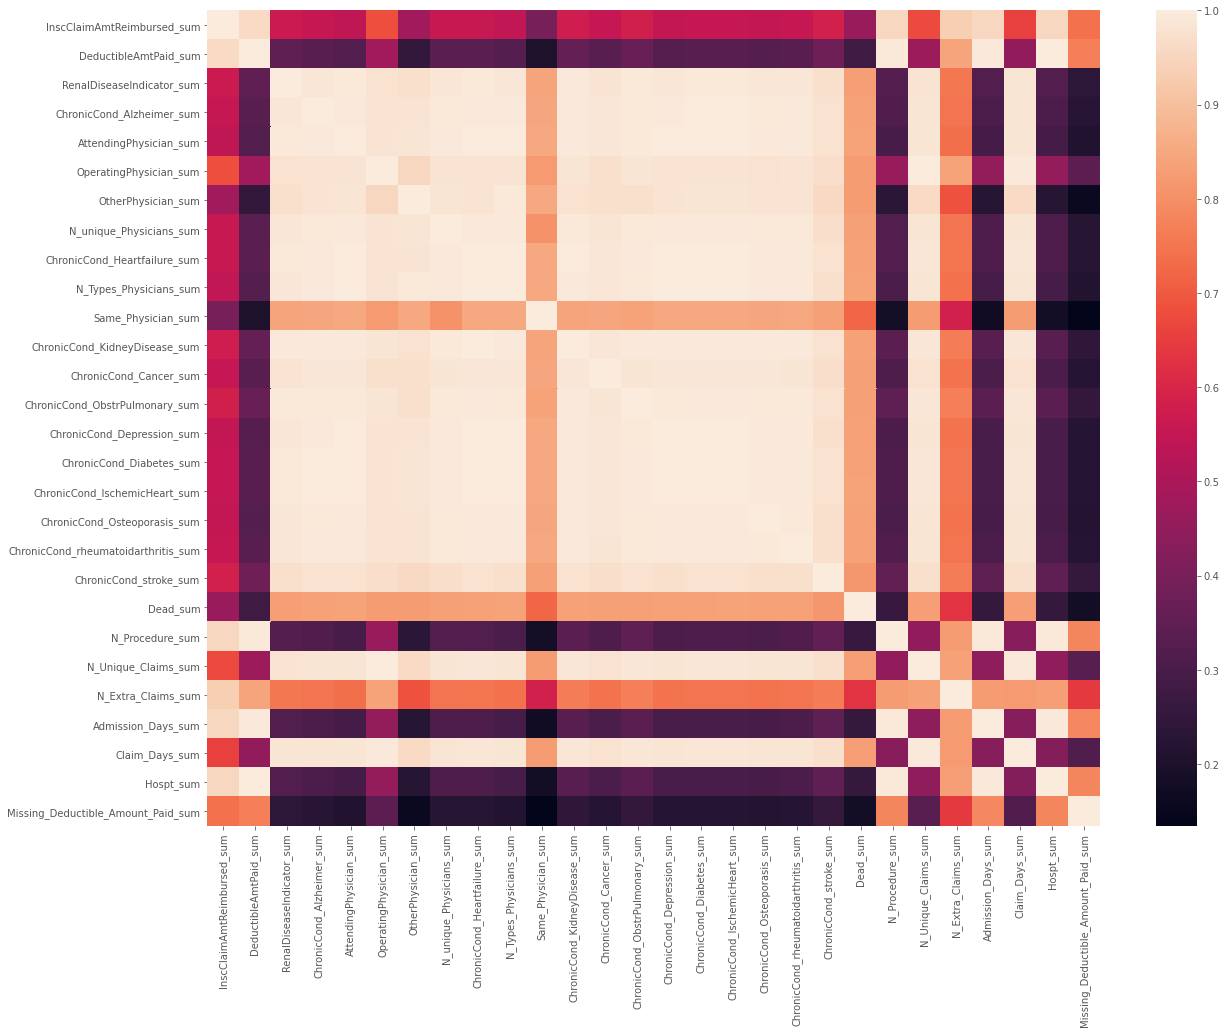

In [311]:
# We plot the correlations in the _sum dataset
plot_corr(_sum)

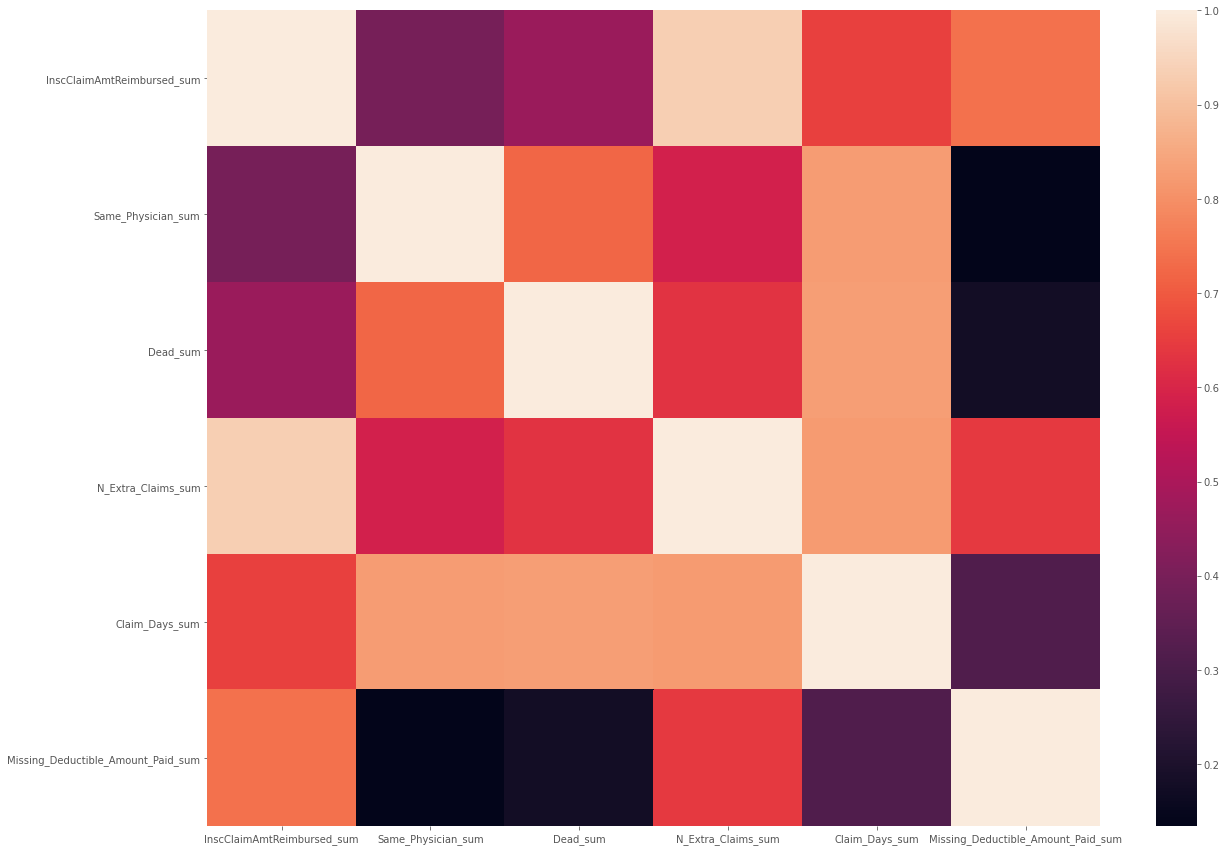

In [312]:
# We drop correlated values 
sum_corr = _sum.drop(['Hospt_sum','AttendingPhysician_sum','OperatingPhysician_sum','Admission_Days_sum',
                      'OtherPhysician_sum','ChronicCond_ObstrPulmonary_sum', 'ChronicCond_Depression_sum',
                      'ChronicCond_Diabetes_sum','ChronicCond_IschemicHeart_sum','ChronicCond_KidneyDisease_sum', 
                      'ChronicCond_Cancer_sum','ChronicCond_Osteoporasis_sum','RenalDiseaseIndicator_sum',
                      'ChronicCond_rheumatoidarthritis_sum','ChronicCond_Heartfailure_sum','N_Unique_Claims_sum',
                      'ChronicCond_Alzheimer_sum','ChronicCond_stroke_sum','N_Procedure_sum','N_unique_Physicians_sum',
                      'N_Types_Physicians_sum','DeductibleAmtPaid_sum'],axis=1) 

# And plot again to check
plot_corr(sum_corr)

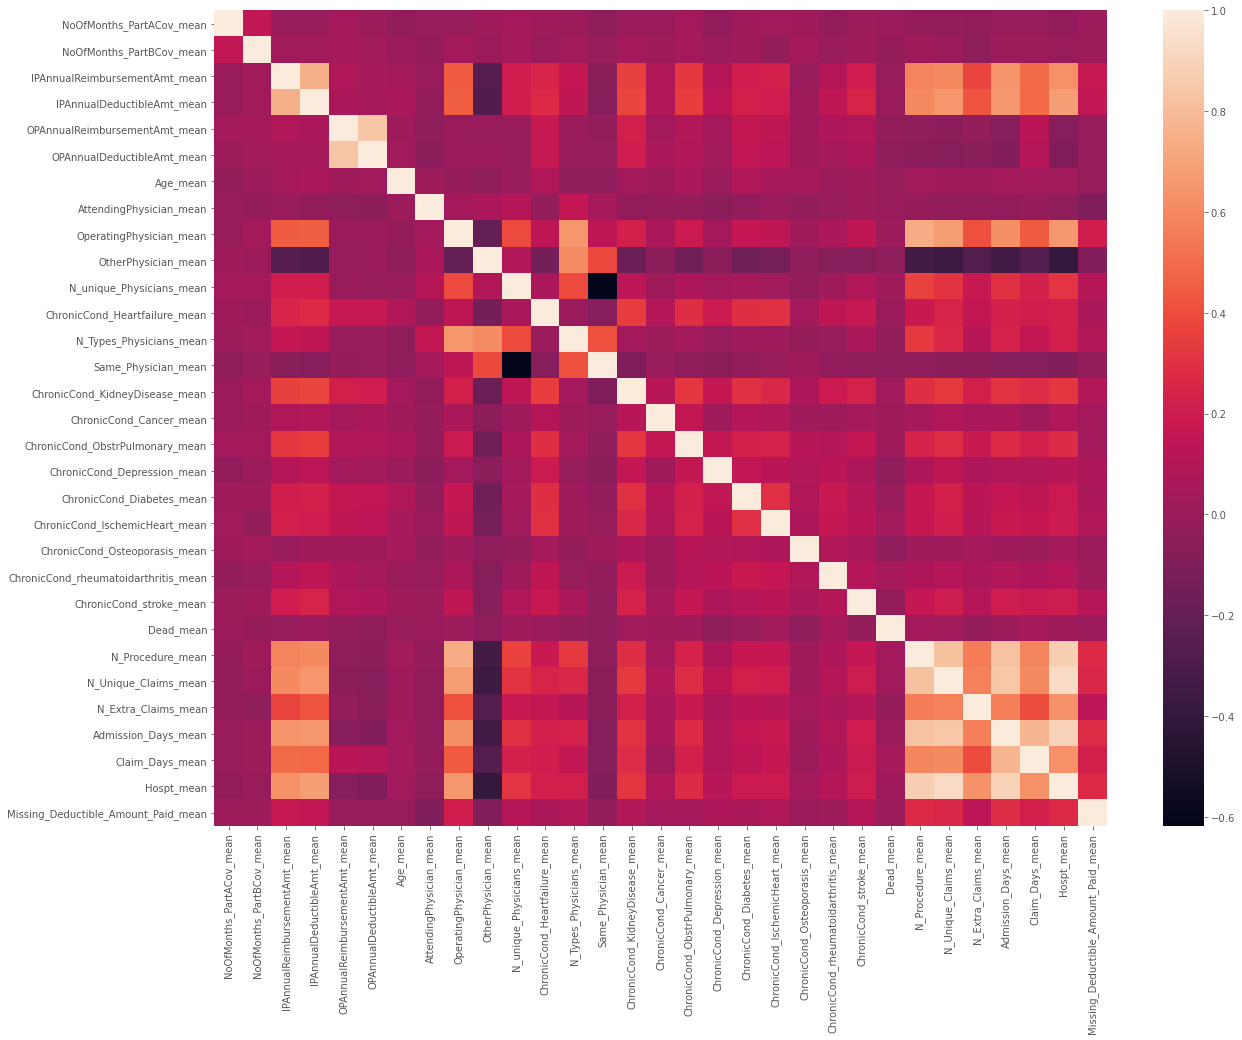

In [313]:
# We plot the correlations in the _mean dataset
plot_corr(_mean)

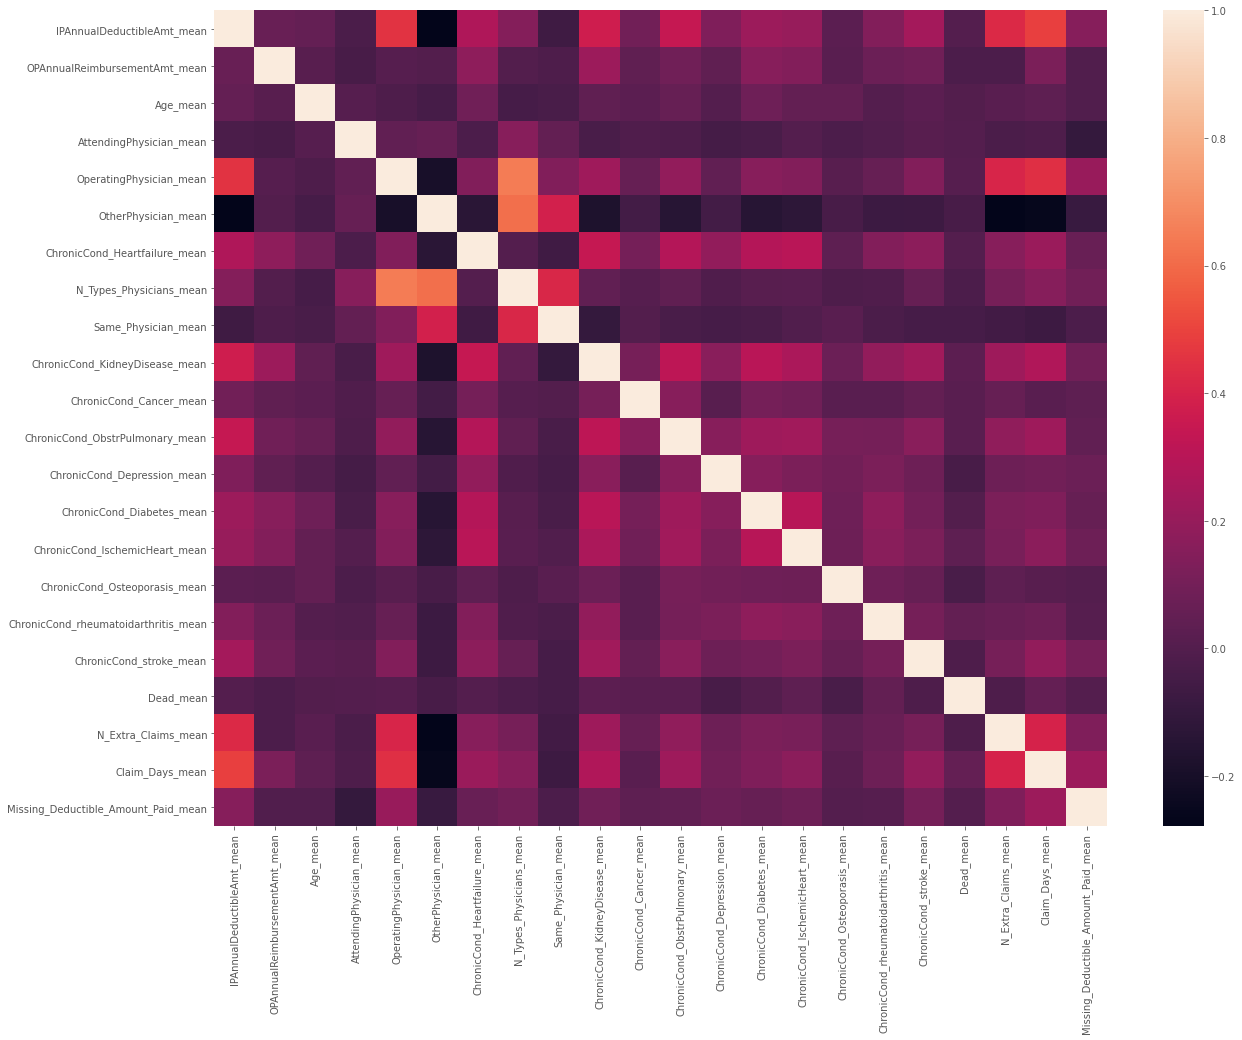

In [314]:
# We drop correlated values 
mean_corr = _mean.drop(['Hospt_mean','Admission_Days_mean','N_unique_Physicians_mean','NoOfMonths_PartBCov_mean',
                        'NoOfMonths_PartACov_mean','IPAnnualReimbursementAmt_mean','N_Procedure_mean',
                        'OPAnnualDeductibleAmt_mean', 'N_Unique_Claims_mean'], axis=1) 

# And plot again to check
plot_corr(mean_corr)

# Feature Selection - SHAP values
    We shall use shap plots from a catboost model to find the best parameters

In [315]:
# this function does 3-fold crossvalidation with catboostclassifier          
def cross_val_test(params,train_set,train_label,cat_dims,n_splits=3):
    Skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state = 0) 
    res = []
    for train_index, test_index in Skf.split(train_set,train_label):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]
        
        labels = train_label.iloc[train_index]
        test_labels = train_label.iloc[test_index]

        clf = CatBoostClassifier(**params)
        clf.fit(train, np.ravel(labels), cat_features=cat_dims,verbose=False)

        # We use the recall score to search for the best parameters
        res.append(recall_score(test_labels, clf.predict(test)))
    return np.mean(res)

In [316]:
# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch.paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = cross_val_test(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(ps.bestscore())
    return ps.bestparam()


In [317]:
# This function runs a catboost model on the data we define
def fcatboost(train, test):
    
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.30, random_state=1)
    
    # convert categorical columns to integers
    category_cols = []
    cat_dims = [train_set.columns.get_loc(i) for i in category_cols[:-1]] 
    
    column_names = X_train.columns
    
    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
    
    X_train.columns = column_names
    X_test.columns = column_names

    params = {'depth':[3,1,2,6,4,5,7,8,9,10],
              'iterations':[250,100,500,1000],
              'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
              'l2_leaf_reg':[3,1,5,10,100],
              'border_count':[32,5,10,20,50,100,200],
              'thread_count':4,
              'random_seed':2}

    bestparams = catboost_param_tune(params,X_train,y_train,[])

    model = CatBoostClassifier(**bestparams)
    model.fit(X_train,y_train,verbose=False)

    
    return model, X_train, X_test, y_train, y_test

In [318]:
# This function plots the shap values from the model
def catboost_shap_plot(model, X_train, y_train):
    
    shap.initjs()

    shap_values = model.get_feature_importance(Pool(X_train,y_train), type='ShapValues')

    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    print('\nShap features importance:')

    # summarize the effects of all the features
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    shap.summary_plot(shap_values, X_train)

We run the catboost model on the sum dataset first

In [319]:
sum_df = sum_corr.merge(target, left_on='Provider_sum', right_on='Provider', how='left')

model_sum, X_train, X_test, y_train, y_test = fcatboost(sum_df.drop(['Provider','target','Provider_sum'], axis = 1),
                                                    sum_df.target)

0.4543847568338891
0.4543847568338891
0.4543847568338891
0.48464187350232624
0.501193755925966
0.5067493111970379
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5094811754852752
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5150596878523224
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092
0.5179292929671092



Shap features importance:


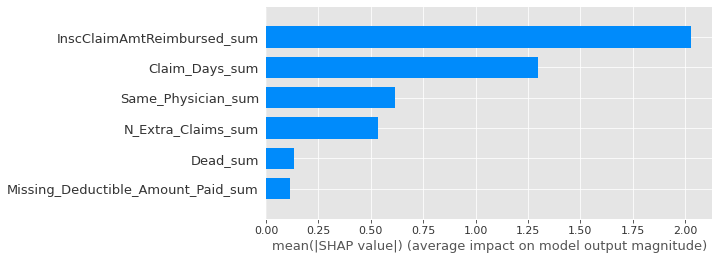

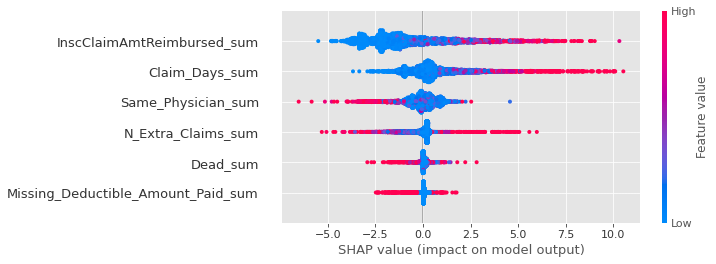

In [320]:
catboost_shap_plot(model_sum, X_train, y_train)

>     From the plots, we decide on the variables InscClaimAmtReimbursed_sum, N_Extra_Claims_sum and Claim_Days_sum

We run the catboost model on the mean dataset 

In [321]:
mean_corr = mean_corr.merge(target, left_on='Provider_mean', right_on='Provider', how='left')

model_mean, X_train, X_test, y_train, y_test = fcatboost(mean_corr.drop(['Provider','target','Provider_mean'], axis = 1),
                                                    mean_corr.target)

0.29648760333455215
0.29648760333455215
0.29917355367727344
0.30757575747268195
0.30757575747268195
0.30757575747268195
0.30757575747268195
0.30757575747268195
0.30757575747268195
0.30757575747268195
0.30757575747268195
0.30757575747268195
0.36010101015661383
0.3934113865704377
0.3960514234337988
0.3960514234337988
0.3960514234337988
0.3960514234337988
0.3960514234337988
0.3960514234337988
0.4044536273061766
0.4044536273061766
0.4044536273061766
0.4044536273061766
0.4044536273061766
0.40447658388884594
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645
0.4071395776079645



Shap features importance:


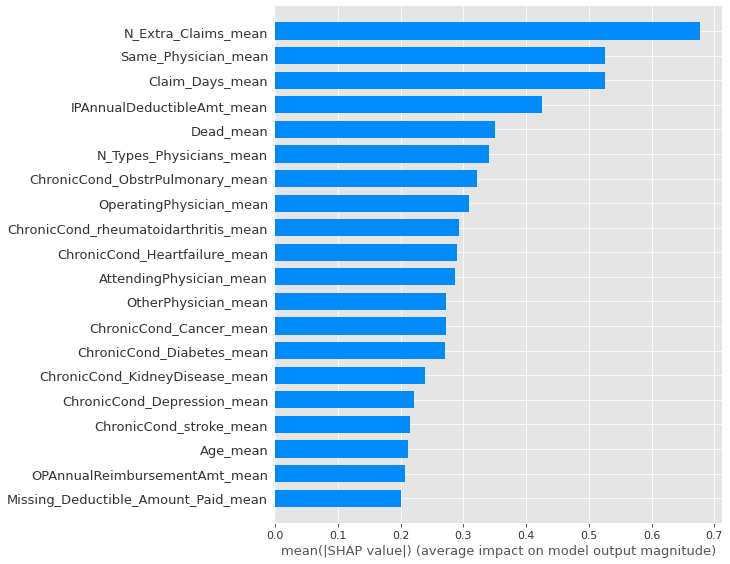

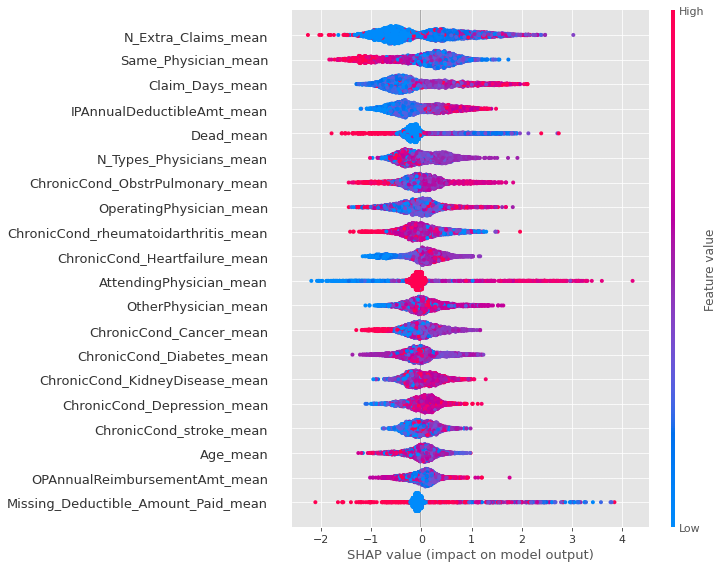

In [322]:
catboost_shap_plot(model_mean, X_train, y_train)

> Looking at the graph of SHAP values, we decide to use the variables: AttendingPhysician_mean,Missing_Deductible_Amount_Paid_mean,Claim_Days_mean and N_Extra_Claims_mean

# Features Selection - Final draft

Based on the previous shap plots we can obtain the variables of interest from the sum and mean datasets to test our models, we also add the variables from the count dataset and the provider and target.

In [323]:
df = _total[['Claim_Days_sum','InscClaimAmtReimbursed_sum', 'N_Extra_Claims_sum',
             'Claim_Days_mean','N_Extra_Claims_mean', 'Same_Physician_mean','AttendingPhysician_mean','Missing_Deductible_Amount_Paid_mean',
             'BeneID_count','ClaimID_count',
             'Provider','target']]

 # Modeling - Catboost

In [324]:
def cm_Score(model, df):
    recall = np.mean(cross_val_score(model, df.drop(['Provider','target'], axis = 1), df.target, cv=3, scoring='recall'))
    accuracy = np.mean(cross_val_score(model, df.drop(['Provider','target'], axis = 1), df.target, cv=3, scoring='accuracy'))
    
    print('Accuracy Score: {}'.format(accuracy))
    print('Recall Score: {}'.format(recall))
   

In [325]:
model, X_train, X_test, y_train, y_test = fcatboost(df.drop(['Provider','target'], axis = 1), df.target)

0.47114325079022473
0.47114325079022473
0.476285583104747
0.47910927460181874
0.5040174471050292
0.509550045747206
0.5150596876933343
0.5150596876933343
0.5150596876933343
0.5150596876933343
0.5150596876933343
0.5150596876933343
0.5150596876933343
0.5233471073992633
0.5233471073992633
0.5233471073992633
0.5233471073992633
0.5233471073992633
0.5233471073992633
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.5261248852002294
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555
0.526147842042555


    The best catboost model has recall of 0.53

# Modeling - Logistic Regression

In [326]:
def flogistic(df, penalty):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Provider','target'], axis = 1),df.target, 
                                                  test_size=0.30, random_state=1)

    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
    
    #Liblinear for small datasets of binary classes
    logreg = LogisticRegression(penalty= penalty,solver= 'liblinear',class_weight='balanced', random_state = 5 , C = 0.001)
    
    cm_Score(logreg, df)
    

In [327]:
# Logistic regression with a L1 penalization
flogistic(df, 'l1')

Accuracy Score: 0.8042560871078382
Recall Score: 0.9110195360195359


In [328]:
# Logistic regression with a L2 penalization
flogistic(df, 'l2')

Accuracy Score: 0.576158996728373
Recall Score: 0.9723161453930684


    The best logistic regression has a recall of 0.97

# Modeling - Naive Bayes

In [329]:
def Gaus_bayes(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Provider','target'], axis = 1),df.target, 
                                                  test_size=0.30, random_state=1)


    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))

    gnb = GaussianNB()
    
    cm_Score(gnb, df)

In [330]:
Gaus_bayes(df)

Accuracy Score: 0.9151570081727137
Recall Score: 0.4960434864281018


The naive bayes model has a recall of 0.50